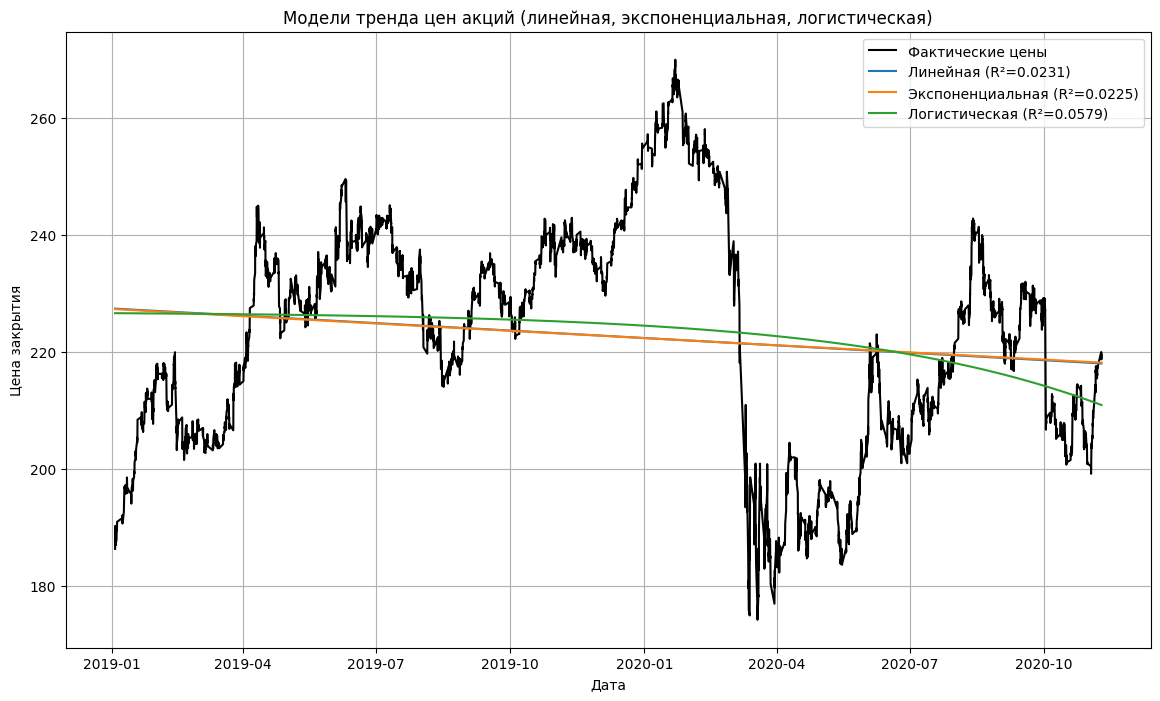

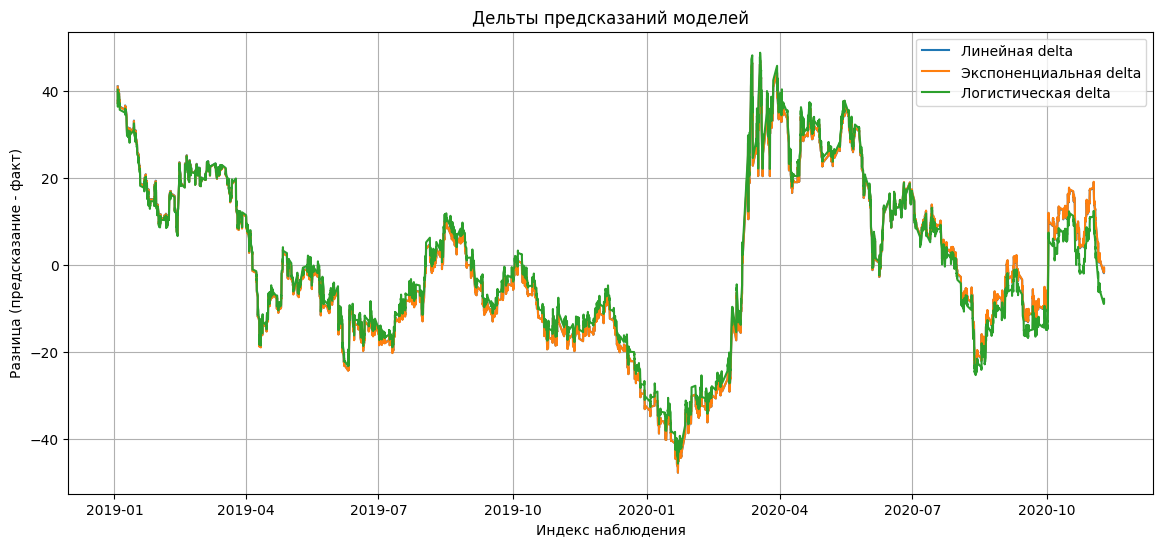

Параметры моделей:
Линейная: a=-9.364890, b=227.415937, R²=0.0231
Экспоненциальная: a=227.321730, b=-0.041005, R²=0.0225
Логистическая: L=226.883205, k=-4.237281, t0=1.609571, R²=0.0579


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


def load_and_prepare_data(filepath, date_column='timestamp', target_column='YNDX'):
    """
    Загружает данные из CSV файла и подготавливает их для анализа.

    Параметры:
    filepath : str
        Путь к CSV файлу
    date_column : str
        Название столбца с датами
    target_column : str
        Название целевого столбца

    Возвращает:
    tuple
        (df, t, y) - DataFrame, нормализованная временная ось, целевые значения
    """
    # Загрузка данных
    df = pd.read_csv(filepath)

    # Преобразование даты в datetime
    df[date_column] = pd.to_datetime(df[date_column], unit="s")

    # Удаление строк с NaN в целевой переменной
    df = df.dropna(subset=[target_column]).copy()

    # Сортировка по дате
    df = df.sort_values(date_column)

    # Преобразование даты в числовую ось
    df['t'] = (df[date_column] - df[date_column].min()).dt.total_seconds()

    # Нормализация временной оси для численной стабильности
    t_min = df['t'].min()
    t_max = df['t'].max()
    df['t_norm'] = (df['t'] - t_min) / (t_max - t_min)  # Нормализация к [0, 1]

    # Извлечение значений
    t = df['t_norm'].values
    y = df[target_column].values

    return df, t, y


def fit_linear_model(t, y):
    """
    Обучает линейную модель y = a*t + b.

    Параметры:
    t : array-like
        Нормализованная временная ось [0, 1]
    y : array-like
        Целевые значения

    Возвращает:
    tuple
        (a, b, y_pred, r2) - параметры модели, предсказания, R²
    """
    coeffs = np.polyfit(t, y, 1)
    a, b = coeffs
    y_pred = a * t + b
    r2 = r2_score(y, y_pred)

    return a, b, y_pred, r2


def fit_exponential_model(t, y):
    """
    Обучает экспоненциальную модель y = a * exp(b*t).

    Параметры:
    t : array-like
        Нормализованная временная ось [0, 1]
    y : array-like
        Целевые значения

    Возвращает:
    tuple
        (a, b, y_pred, r2) - параметры модели, предсказания, R²
    """
    def exp_model(t, a, b):
        return a * np.exp(b * t)

    # Начальные приближения
    p0 = [np.mean(y), 1.0]
    try:
        params, _ = curve_fit(exp_model, t, y, p0=p0, maxfev=5000)
        a, b = params
    except (RuntimeError, ValueError) as e:
        print(f"Ошибка при обучении экспоненциальной модели: {e}")
        # Возвращаем нулевую модель в случае ошибки
        a, b = np.mean(y), 0.0

    y_pred = exp_model(t, a, b)
    r2 = r2_score(y, y_pred)

    return a, b, y_pred, r2


def fit_logistic_model(t, y):
    """
    Обучает логистическую модель y = L / (1 + e^(-k*(t - t0))).

    Параметры:
    t : array-like
        Нормализованная временная ось [0, 1]
    y : array-like
        Целевые значения

    Возвращает:
    tuple
        (L, k, t0, y_pred, r2) - параметры модели, предсказания, R²
    """
    def logistic_model(t, L, k, t0):
        return L / (1 + np.exp(-k * (t - t0)))

    # Начальные приближения для нормализованного времени
    p0 = [max(y) * 1.5, 5.0, 0.5]  # L немного больше max(y), k=5, t0=0.5

    try:
        params, _ = curve_fit(logistic_model, t, y, p0=p0, maxfev=10000)
        L, k, t0 = params
    except (RuntimeError, ValueError) as e:
        print(f"Ошибка при обучении логистической модели: {e}")
        # Возвращаем нулевую модель в случае ошибки
        L, k, t0 = max(y), 1.0, 0.5

    y_pred = logistic_model(t, L, k, t0)
    r2 = r2_score(y, y_pred)

    return L, k, t0, y_pred, r2


def calculate_delta(y_pred, y_true):
    """
    Вычисляет разницу между предсказанными значениями и реальными.

    Параметры:
    y_pred : array-like
        Массив предсказанных значений модели.
    y_true : array-like
        Массив реальных значений.

    Возвращает:
    np.ndarray
        Массив разниц (y_pred - y_true).
    """
    y_pred = np.asarray(y_pred)
    y_true = np.asarray(y_true)
    return y_pred - y_true


def plot_models(df, date_column, y_true, models_results):
    """
    Строит график с фактическими данными и моделями.

    Параметры:
    df : pd.DataFrame
        DataFrame с данными
    date_column : str
        Название столбца с датами
    y_true : array-like
        Фактические значения
    models_results : dict
        Словарь с результатами моделей вида:
        {
            'model_name': {'y_pred': [...], 'r2': ...},
            ...
        }
    """
    plt.figure(figsize=(14, 8))

    # Фактические данные
    plt.plot(df[date_column], y_true, label="Фактические цены", color="black")

    # Предсказания моделей
    for model_name, results in models_results.items():
        plt.plot(df[date_column], results['y_pred'],
                label=f"{model_name} (R²={results['r2']:.4f})")

    plt.xlabel("Дата")
    plt.ylabel("Цена закрытия")
    plt.title("Модели тренда цен акций (линейная, экспоненциальная, логистическая)")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_deltas(df, date_column, deltas_dict):
    """
    Строит график дельт (разниц между предсказаниями и фактическими значениями).

    Параметры:
    deltas_dict : dict
        Словарь с дельтами вида {'model_name': deltas_array, ...}
    """
    plt.figure(figsize=(14, 6))

    for model_name, deltas in deltas_dict.items():
        plt.plot(df[date_column], deltas, label=f"{model_name} delta")

    plt.xlabel("Индекс наблюдения")
    plt.ylabel("Разница (предсказание - факт)")
    plt.title("Дельты предсказаний моделей")
    plt.legend()
    plt.grid(True)
    plt.show()


def analyze_stock_trends(filepath, date_column='timestamp', target_column='SBER'):
    """
    Основная функция для анализа трендов акций.

    Параметры:
    filepath : str
        Путь к CSV файлу с данными
    date_column : str
        Название столбца с датами
    target_column : str
        Название целевого столбца
    """
    # Загрузка и подготовка данных
    df, t, y = load_and_prepare_data(filepath, date_column, target_column)

    # Обучение моделей
    a_lin, b_lin, y_pred_lin, r2_lin = fit_linear_model(t, y)
    a_exp, b_exp, y_pred_exp, r2_exp = fit_exponential_model(t, y)
    L_log, k_log, t0_log, y_pred_log, r2_log = fit_logistic_model(t, y)

    # Сбор результатов
    models_results = {
        'Линейная': {'y_pred': y_pred_lin, 'r2': r2_lin},
        'Экспоненциальная': {'y_pred': y_pred_exp, 'r2': r2_exp},
        'Логистическая': {'y_pred': y_pred_log, 'r2': r2_log}
    }

    # Расчет дельт
    deltas_dict = {
        'Линейная': calculate_delta(y_pred_lin, y),
        'Экспоненциальная': calculate_delta(y_pred_exp, y),
        'Логистическая': calculate_delta(y_pred_log, y)
    }

    # Построение графиков
    plot_models(df, date_column, y, models_results)
    plot_deltas(df, date_column, deltas_dict)

    # Вывод параметров моделей
    print("Параметры моделей:")
    print(f"Линейная: a={a_lin:.6f}, b={b_lin:.6f}, R²={r2_lin:.4f}")
    print(f"Экспоненциальная: a={a_exp:.6f}, b={b_exp:.6f}, R²={r2_exp:.4f}")
    print(f"Логистическая: L={L_log:.6f}, k={k_log:.6f}, t0={t0_log:.6f}, R²={r2_log:.4f}")

    return {
        'df': df,
        't': t,
        'y': y,
        'models': models_results,
        'deltas': deltas_dict,
        'params': {
            'linear': {'a': a_lin, 'b': b_lin},
            'exponential': {'a': a_exp, 'b': b_exp},
            'logistic': {'L': L_log, 'k': k_log, 't0': t0_log}
        }
    }


# Пример использования
if __name__ == "__main__":
    # Анализ данных из файла
    try:
        results = analyze_stock_trends('CLOSE.csv')
    except Exception as e:
        print(f"Ошибка при выполнении анализа: {e}")